In [30]:
%pwd

'/Users/sebbyzhao/Research/RecSys/recsys'

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import torch
import os
import seaborn as sns
import implicit
import pandas as pd
from scipy import sparse
from numpy.linalg import svd
import numpy as np
from als import ALSModel
from utils import apk, validation, train

In [6]:
DATA_DIR = '../data/ml-100k/'

In [83]:
training_data = pd.read_csv(os.path.join(DATA_DIR, 'ua.base'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
training_data['user_id'] = training_data['user_id'] 
training_data['item_id'] = training_data['item_id'] 
training_data.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [104]:
test_data = pd.read_csv(os.path.join(DATA_DIR, 'ua.test'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
test_data['user_id'] = test_data['user_id'] - 1
test_data['item_id'] = test_data['item_id'] - 1
test_data.head()

,user_id,item_id,rating,timestamp
0,0,19,4,887431883
1,0,32,4,878542699
2,0,60,4,878542420
3,0,116,3,874965739
4,0,154,2,878542201


In [105]:
test_rating_matrix = pd.pivot_table(test_data, index='user_id', columns='item_id', values='rating', fill_value=0)
test_rating_matrix.head()

item_id,0,1,2,3,4,5,6,7,8,9,...,1590,1591,1599,1611,1616,1645,1652,1655,1661,1663
user_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
test_proxy_array = test_rating_matrix.values > 0
test_proxy_array = test_proxy_array.astype(int)
test_proxy_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [107]:
test_rating_array = test_rating_matrix.values > 3
test_true_array = test_rating_array.astype(int)
test_true_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [108]:
rating_matrix = pd.pivot_table(training_data, values='rating', index='user_id', columns='item_id', fill_value=0)
rating_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
rating_proxy = rating_matrix.copy().applymap(lambda x: 1 if x > 0 else 0)
rating_proxy.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
rating_proxy_array = rating_proxy.values

In [54]:
model = ALSModel(rating_proxy_array)

In [36]:
test_proxy_array[1]

array([0, 0, 0, ..., 0, 0, 0])

In [59]:
validation(rating_proxy_array, test_proxy_array, test_true_array, model)

(0.012903095490582236, 0.01567714223861651)

In [58]:
model, training_losses, proxy_losses, true_losses = train(model, rating_proxy_array, test_proxy_array, test_true_array, num_epochs=20)

===
Epoch:  0
Training Error:  0.3117695353248311
Validation Proxy MAP@K:  0.014552298473295294
Validation True MAP@K:  0.01703841987091368
===
Epoch:  1
Training Error:  0.25605710618268535
Validation Proxy MAP@K:  0.01394014374926358
Validation True MAP@K:  0.017061304009840846
===
Epoch:  2
Training Error:  0.24182073285326766
Validation Proxy MAP@K:  0.013510873773334008
Validation True MAP@K:  0.016152073285619968
===
Epoch:  3
Training Error:  0.2349605307003734
Validation Proxy MAP@K:  0.013355341783231497
Validation True MAP@K:  0.01623704985509384
===
Epoch:  4


KeyboardInterrupt: 

In [ ]:
training_losses, proxy_losses, true_losses 

([0.9385453692981001,
  0.30827471885695396,
  0.25477400700040265,
  0.2410100659226097,
  0.23436625917864157,
  0.23056018665256892,
  0.22818435473066803,
  0.2266153737456271,
  0.22553423708030002,
  0.22476313822985255,
  0.22419717950493182,
  0.22377159829734003,
  0.22344483427120235,
  0.22318932911347192,
  0.2229862275181938,
  0.22282239789659986,
  0.22268845212435665,
  0.22257754514528777,
  0.2224846839151346,
  0.2224061025905471,
  0.22233898170743335,
  0.22228114463102183,
  0.22223094515662853,
  0.22218707497585943,
  0.22214851764777147,
  0.22211444670533628,
  0.2220842195532779,
  0.22205731758748462,
  0.2220332842512831,
  0.22201174837214507,
  0.22199244173031385,
  0.22197505691756964,
  0.2219593730309447,
  0.2219452278455124,
  0.22193242092919643,
  0.2219208107887865,
  0.22191028750313865,
  0.22190070689127855,
  0.22189198614135855,
  0.2218840157899667,
  0.22187672893723034,
  0.22187003171302966,
  0.2218638944637826,
  0.2218582429041444,
  

In [60]:
baseline_recs = test_data.groupby('item_id').count().sort_values('user_id', ascending=False).index.values[:10]
baseline_recs

array([257, 287,  49, 293, 299, 285, 312, 180,  99, 747])

In [65]:
# Proxy objective baseline
proxy_obj_baseline = np.mean([apk(baseline_recs, np.where(test_proxy_array[i, :])[0], np.where(test_true_array[i, :])[0])[0] for i in range(len(test_rating_array))])
print("Proxy objective baseline: " + str(proxy_obj_baseline))

Proxy objective baseline: 0.01173605850965342


In [ ]:
# Figure out why there's a diff between the two options.
# Not all item ids are inputted.

In [123]:
# True objective baseline
true_obj_baseline = np.mean([apk(baseline_recs, np.where(test_proxy_array[i, :])[0], np.where(test_rating_array[i, :])[0])[1] for i in range(len(test_rating_array))])
print("True objective baseline: " + str(true_obj_baseline))

True objective baseline: 0.01259633030188628


In [210]:
data = np.hstack([np.array(training_losses).reshape(-1, 1), np.array(proxy_losses).reshape(-1, 1), np.array(true_losses).reshape(-1, 1), np.full((len(training_losses), 1), proxy_obj_baseline), np.full((len(training_losses), 1), true_obj_baseline)])
data = pd.DataFrame(data)
data = data.rename(mapper={0: 'Training Loss', 1: 'Validation Proxy MAP@K', 2: 'Validation True MAP@K', 3: 'Proxy MAP@K Baseline', 4: 'True MAP@K Baseline'}, axis=1)
data

,Training Loss,Validation Proxy MAP@K,Validation True MAP@K,Proxy MAP@K Baseline,True MAP@K Baseline
0,0.938545,0.107595,0.015703,0.035147,0.012596
1,0.308275,0.118791,0.014742,0.035147,0.012596
2,0.254774,0.116997,0.013883,0.035147,0.012596
3,0.241010,0.118031,0.014280,0.035147,0.012596
4,0.234366,0.119711,0.014330,0.035147,0.012596
...,...,...,...,...,...
95,0.221764,0.121545,0.013387,0.035147,0.012596
96,0.221764,0.121633,0.013453,0.035147,0.012596
97,0.221763,0.121747,0.013456,0.035147,0.012596
98,0.221763,0.121617,0.013443,0.035147,0.012596


<Axes: >

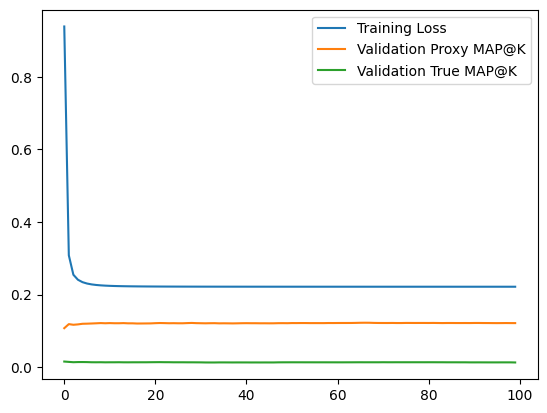

In [211]:
sns.lineplot(data=data[['Training Loss', 'Validation Proxy MAP@K', 'Validation True MAP@K']], dashes=False)

<Axes: >

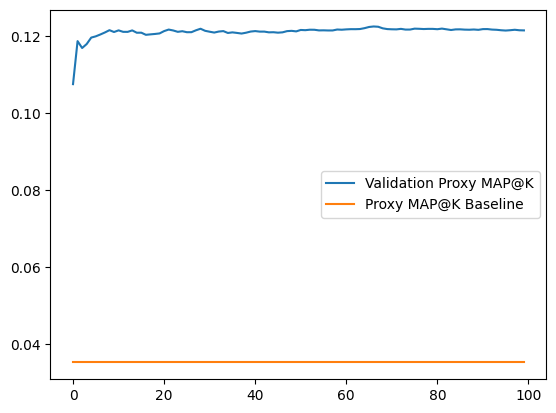

In [212]:
sns.lineplot(data=data[['Validation Proxy MAP@K', 'Proxy MAP@K Baseline']].iloc[:100], dashes=False)

<Axes: >

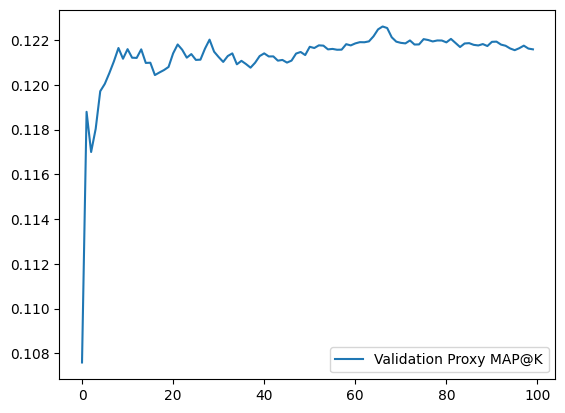

In [213]:
sns.lineplot(data=data[['Validation Proxy MAP@K']].iloc[:100], dashes=False)

<Axes: >

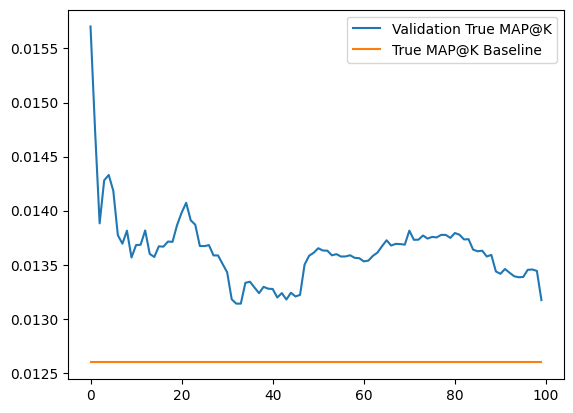

In [214]:
sns.lineplot(data=data[['Validation True MAP@K', 'True MAP@K Baseline']].iloc[:100], dashes=False)

<Axes: ylabel='Validation True MAP@K'>

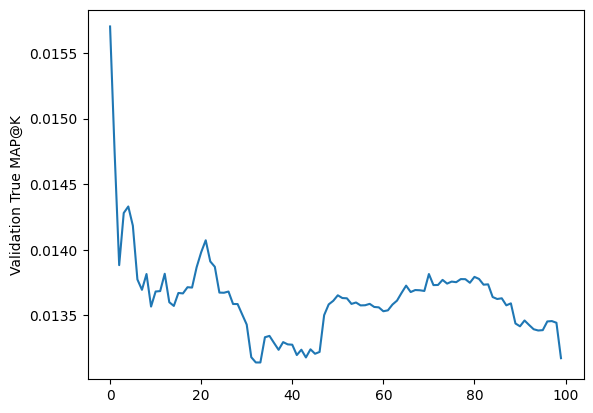

In [215]:
sns.lineplot(data=data['Validation True MAP@K'].iloc[:100], dashes=False)

In [235]:
def simulated_data(n, users, items, corr, sd=1):
    """
    Generates fake data 

    Parameters:
    n: int = number of data points to generate for each user
    users: int = number of users
    items: int = number of items
    corr: float = correlation between proxy objective and true objective
    sd: float = standard deviation of noise

    Returns:
    proxy_data: pd.DataFrame = proxy data
    true_data: pd.DataFrame = underlying true distribution
    """
    true_data = pd.DataFrame()
    proxy_data = pd.DataFrame()

    for i in range(users):
        # Generate true data
        sampled_items = np.random.choice(items, size=n, replace=False)
        true_data_i = pd.DataFrame()
        true_data_i['user_id'] = [i] * n
        true_data_i['item_id'] = sampled_items
        # True ratings, drawn uniformly from 0 to 5
        true_data_i['rating'] = np.random.Generator.uniform(0, 5, size=n)
        true_data = pd.concat([true_data, true_data_i], axis=0)

        # Generate proxy data
        proxy_data_i = pd.DataFrame()
        proxy_data_i['user_id'] = [i] * n
        proxy_data_i['item_id'] = sampled_items
        # Proxy ratings, drawn from normal distribution with mean true rating and standard deviation sd
        proxy_data_i['rating'] = true_data_i['rating'] * corr + np.random.normal(size=n, loc=0, scale=sd)
        proxy_data = pd.concat([proxy_data, proxy_data_i], axis=0)
    
    return proxy_data, true_data

    
    

In [ ]:
def simulated_data_indicators(n, users, items, corr):
    """
    Generates fake data 

    Parameters:
    n: int = number of data points to generate for each user
    users: int = number of users
    items: int = number of items
    corr: float = correlation between proxy objective and true objective
    sd: float = standard deviation of noise

    Returns:
    proxy_data: pd.DataFrame = proxy data
    true_data: pd.DataFrame = underlying true distribution
    """
    true_data = pd.DataFrame()
    proxy_data = pd.DataFrame()

    for i in range(users):
        # Generate true data
        sampled_items = np.random.choice(items, size=n, replace=False)
        true_data_i = pd.DataFrame()
        true_data_i['user_id'] = [i] * n
        true_data_i['item_id'] = sampled_items
        # True ratings, drawn uniformly from 0 to 5
        true_data_i['rating'] = np.random.randint(0, 2, size=n)
        true_data = pd.concat([true_data, true_data_i], axis=0)

        # Generate proxy data
        proxy_data_i = pd.DataFrame()
        proxy_data_i['user_id'] = [i] * n
        proxy_data_i['item_id'] = sampled_items
        # Proxy ratings, drawn from normal distribution with mean true rating and standard deviation sd
        proxy_data_i['rating'] = 
        proxy_data = pd.concat([proxy_data, proxy_data_i], axis=0)
    
    return proxy_data, true_data

    
    

In [239]:
proxy_data, true_data = simulated_data(10, 1000, 2000, 1, sd=1)

In [242]:
# Split into train and validation (shouldn't be too hard)
# Find some way to turn this into a proxy objective -> with implicit dataset I could just use the ratings?
proxy_data

,user_id,item_id,rating
0,0,1862,2.390586
1,0,1511,6.406821
2,0,1051,2.068357
3,0,1262,2.110399
4,0,1488,0.739352
...,...,...,...
5,999,486,5.331730
6,999,1527,-0.868833
7,999,506,4.422085
8,999,1703,3.151032


In [ ]:
proxy_data, true_data = simulated_data(10, 1000, 2000, 1, sd=1)

In [240]:
proxy_data, true_data = simulated_data(10, 1000, 2000, 0.5, sd=1)